<a href="https://colab.research.google.com/github/royam0820/LLM_OCR/blob/main/amr_4_RAG_Langchain_FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook demonstrates a complete **Retrieval-Augmented Generation (RAG) pipeline using LangChain and FAISS, a vector similarity search library** developed by Facebook AI. The goal is to build a QA system that can retrieve relevant context from documents and generate accurate, context-aware answers using a Large Language Model (LLM), specifically OpenAI's GPT.

The notebook walks through the following core components of a RAG workflow:
- Loading and chunking documents.
- Embedding text using OpenAI's embedding model.
- Storing and querying those embeddings using FAISS (Facebook AI Similarity Search).
- Constructing a retrieval-based question-answering chain with LangChain.
- Executing natural language queries and obtaining LLM-generated answers based on retrieved context.

This setup allows users to enhance LLM performance by grounding the response in external knowledge not seen during training.

# Combining Text and Pictures

How it works:

- **Installs and Imports**: Installs clip-interrogator and imports necessary libraries.
- **Loads Data**: Loads the Markdown file and the image.
- **Embeddings**:
  - Gets text embeddings using OpenAIEmbeddings.
  - Gets image embeddings using clip_interrogator.Interrogator().
  - Combines the embeddings into a single list.
- **FAISS Store**: Creates a FAISS store using the combined embeddings, associating each with its source.
- **RetrievalQA**: Sets up a RetrievalQA chain for querying.
- **Query**: Runs a sample query against the data.


## Setup

Install required packages for the Retrieval-Augmented Generation (RAG) pipeline:
- langchain & langchain-community: for chaining language models with tools and data sources.
- openai: to interact with OpenAI's GPT models.
- faiss-cpu: for similarity search in vector databases.
- unstructured: to extract structured data from raw documents (PDFs, HTML, etc.).
- tiktoken: used by OpenAI models to count tokens efficiently.
- pillow: image processing (e.g., used in CLIP workflows).
- sentence-transformers: for generating vector embeddings from text using transformer models like SBERT.
- transformers: HuggingFace’s library for working with pre-trained models like BERT, GPT, T5, etc.


In [1]:
!pip install -q langchain langchain langchain-community openai faiss-cpu unstructured tiktoken pillow sentence-transformers transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.1/420.1 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━

In [2]:
# Calling the OpenAI API Key
import os
from google.colab import userdata

api_key = os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')


In [3]:
if api_key is not None:
    print("API key is exported and available.")
else:
    print("API key is not exported or is empty.")

API key is exported and available.


In [4]:
from IPython.display import Image as IPyImage, display

In [5]:
import os, re, numpy as np
import textwrap
from PIL import Image
from langchain.schema import Document
from langchain.llms import OpenAI # Import the OpenAI class from langchain
from langchain.chains.summarize import load_summarize_chain # Import the load_summarize_chain function
from langchain_community.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter # Import the RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer

## Configuration

In [6]:
# ----- CONFIGURATION -----
markdown_path = "/content/DeepSeek Math.md"
images_dir = "/content"  # images are located in /content

# For text embeddings (using OpenAIEmbeddings) and for image embeddings (using a CLIP model).
text_embedder = OpenAIEmbeddings()  # OPENAI_API_KEY must be set in the environment
image_embedder = SentenceTransformer("clip-ViT-B-32")  # make sure to install sentence-transformers

# Determine the image embedding dimension from the chosen model (CLIP-ViT-B-32 typically outputs 512-d vectors)
image_emb_dim = 512

<ipython-input-6-04164aa48493>:6: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  text_embedder = OpenAIEmbeddings()  # OPENAI_API_KEY must be set in the environment
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

NB: ignore the warning error, we do not need to be authenticated to the HuggingFace Hub.

## Step 1: Processing markdown and inline images

In [7]:
# ----- STEP 1: READ MARKDOWN AND EXTRACT INLINE IMAGE REFERENCES -----
with open(markdown_path, "r", encoding="utf-8") as f:
    markdown_text = f.read()

# Regex pattern to find image references of the form: ![[filename]]
pattern = r'!\[\[(.*?)\]\]'
image_refs = re.findall(pattern, markdown_text)
print("Found image references:", image_refs)

Found image references: ['2402.03300v3_img_1.jpeg', '2402.03300v3_img_2.jpeg', '2402.03300v3_img_3.jpeg', '2402.03300v3_img_4.jpeg', '2402.03300v3_img_5.jpeg', '2402.03300v3_img_6.jpeg', '2402.03300v3_img_7.jpeg']


## Step 2: Compute image embeddings

In [8]:
# ----- STEP 2: COMPUTE IMAGE EMBEDDINGS -----
image_embeddings = []
for img_ref in image_refs:
    img_path = os.path.join(images_dir, img_ref)
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert("RGB")
            # Convert image to numpy array (the SentenceTransformer model accepts PIL.Image)
            emb = image_embedder.encode(img)
            image_embeddings.append(emb)
        except Exception as e:
            print(f"Error processing {img_ref}: {e}")
    else:
        print(f"Image file not found: {img_path}")

if image_embeddings:
    # Average all image embeddings (you can change this to concatenation if desired)
    avg_image_embedding = np.mean(np.array(image_embeddings), axis=0)
else:
    # If no images, create a zero vector
    avg_image_embedding = np.zeros((image_emb_dim,), dtype=np.float32)

NB: the code above aggregates image information into a single vector, which is useful when you need a unified representation of several images—such as for indexing in FAISS or other similarity search applications.

Averaging is a common strategy for aggregating multiple embeddings into a single representation. It ensures that if there are multiple images associated with a document or query, their combined information is captured in a single vector, which can then be used for similarity searches or further processing.

## Step 3: Compute text embeddings

In [9]:
# ----- STEP 3: COMPUTE TEXT EMBEDDING FOR THE MARKDOWN -----
# Generate a text embedding for the markdown text (tokenization happens internally)
text_embedding = text_embedder.embed_documents([markdown_text])[0]

## Step 4: Combine text and image embeddings

In [10]:
# ----- STEP 4: COMBINE TEXT AND IMAGE EMBEDDINGS -----
# Here we concatenate the text embedding and the averaged image embedding.
# (Make sure the text embedding dimension is known; OpenAIEmbeddings typically returns 1536-d vectors.)
combined_embedding = np.concatenate([np.array(text_embedding), np.array(avg_image_embedding)])
print("Combined embedding dimension:", combined_embedding.shape)

Combined embedding dimension: (2048,)


NB: The combined embedding dimension is 2048 because you’re concatenating two vectors: one from the text embedding and one from the image embedding—whose dimensions add up to 2048.

## Step 5: Create a document with markdown text and image metadata

In [11]:
# ----- STEP 5: CREATE A DOCUMENT WITH THE MARKDOWN TEXT AND IMAGE METADATA -----
doc = Document(
    page_content=markdown_text,
    metadata={"image_refs": image_refs}
)

# Prepare the tuple list: (text, combined_embedding)
text_embedding_pairs = [(doc.page_content, combined_embedding)]

NB: The code above creates a LangChain Document containing the raw text (in page_content) plus some metadata (in metadata) referencing the images. Then it prepares a list of tuples, where each tuple holds the text content (doc.page_content) and the combined embedding. This tuple format is often what a vector store expects when indexing documents: it pairs the text data with the vector representation that will be used for similarity searches.

## Step 6: Define a custom embedding class for querying


In [12]:
# Provides a unified interface for embedding models in LangChain
from langchain.embeddings.base import Embeddings

In [13]:
# # ----- STEP 6: DEFINE A CUSTOM EMBEDDING CLASS FOR QUERYING
# class MyEmbeddings(Embeddings):
#         def __init__(self, text_embedder, image_emb_dim):
#             self.text_embedder = text_embedder
#             self.image_emb_dim = image_emb_dim

#         def embed_documents(self, texts):
#             text_embs = self.text_embedder.embed_documents(texts)
#             combined = []
#             for text_emb in text_embs:
#                 text_emb = np.array(text_emb)
#                 image_pad = np.zeros(self.image_emb_dim, dtype=np.float32)
#                 combined.append(np.concatenate([text_emb, image_pad]))
#             return combined

#         def embed_query(self, text):
#             text_emb = np.array(self.text_embedder.embed_query(text))
#             image_pad = np.zeros(self.image_emb_dim, dtype=np.float32)
#             return np.concatenate([text_emb, image_pad])

In [14]:
# ----- STEP 6: DEFINE A CUSTOM EMBEDDING CLASS FOR QUERYING
class MyEmbeddings(Embeddings):
        def __init__(self, text_embedder, image_emb_dim):
            self.text_embedder = text_embedder
            self.image_emb_dim = image_emb_dim

        def embed_documents(self, texts):
            text_embs = self.text_embedder.embed_documents(texts)
            combined = []
            for text_emb in text_embs:
                text_emb = np.array(text_emb)
                image_pad = np.zeros(self.image_emb_dim, dtype=np.float32)
                combined.append(np.concatenate([text_emb, image_pad]))
            return combined

        def embed_query(self, text):
            text_emb = np.array(self.text_embedder.embed_query(text))
            image_pad = np.zeros(self.image_emb_dim, dtype=np.float32)
            return np.concatenate([text_emb, image_pad])

# Create an instance of the custom embedding class
combined_embedder = MyEmbeddings(text_embedder, image_emb_dim)



NB: The class `MyEmbeddings(Embeddings)`
allows you to generate embeddings that have a fixed structure (text embedding + image padding), ensuring that downstream processes (such as similarity searches in FAISS) always work with a consistent vector size, even if only text data is available.

## Step 7: Build the FAISS VECTOR STORE

In [15]:
# ----- STEP 7: BUILD THE FAISS VECTOR STORE -----
store = FAISS.from_embeddings(
    text_embeddings=text_embedding_pairs,
    embedding=combined_embedder, # Now combined_embedder is defined
    metadatas=[doc.metadata]
)

NB: The FAISS vector store isn’t a summarizer—it simply retrieves the stored text (in your case, the whole paper). To get a summary (e.g. two or three paragraphs), you’ll need to pass the retrieved text through a summarization chain or call an LLM with a summarization prompt.

Below is an example using LangChain’s `map_reduce` summarization chain with OpenAI:

## Step 8: Query the index and summarize the results

In [16]:
# ----- STEP 8: QUERY THE INDEX & SUMMARIZE THE RESULTS -----
query = "Summarize the document and show the image referenced in the markdown."
results = store.similarity_search(query)

# Combine all retrieved text from the results
retrieved_text = "\n".join([d.page_content for d in results])

# Use RecursiveCharacterTextSplitter to break the long text into chunks to avoid context length errors
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=200)
chunks = text_splitter.split_text(retrieved_text)
docs_for_summary = [Document(page_content=chunk) for chunk in chunks]

llm = OpenAI(temperature=0)
summarize_chain = load_summarize_chain(llm, chain_type="map_reduce")
summary = summarize_chain.run(docs_for_summary)

# text wrapping for a better summary readability
print("Summary:")
print("\n".join(textwrap.wrap(summary, width=80)))


<ipython-input-16-447a484e8a9b>:13: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  llm = OpenAI(temperature=0)
<ipython-input-16-447a484e8a9b>:15: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = summarize_chain.run(docs_for_summary)


Summary:
 DeepSeekMath is a high-performing language model trained on 120B math-related
tokens and uses a new optimization technique called Group Relative Policy
Optimization. The paper discusses advancements in mathematical reasoning made
possible by large language models and introduces two open-source models,
DeepSeekMath-Base 7B and DeepSeekMath-Instruct 7B. It also explores the use of
reinforcement learning and code training to improve mathematical reasoning and
proposes a unified paradigm for understanding different training methods. The
article mentions other language models and tools being developed for
mathematical problem-solving. The GRPO algorithm, which combines data sources,
reward functions, and gradient coefficients, is used to optimize a policy model
in the SFT dataset.


## Step 9: Display Image referenced in the results

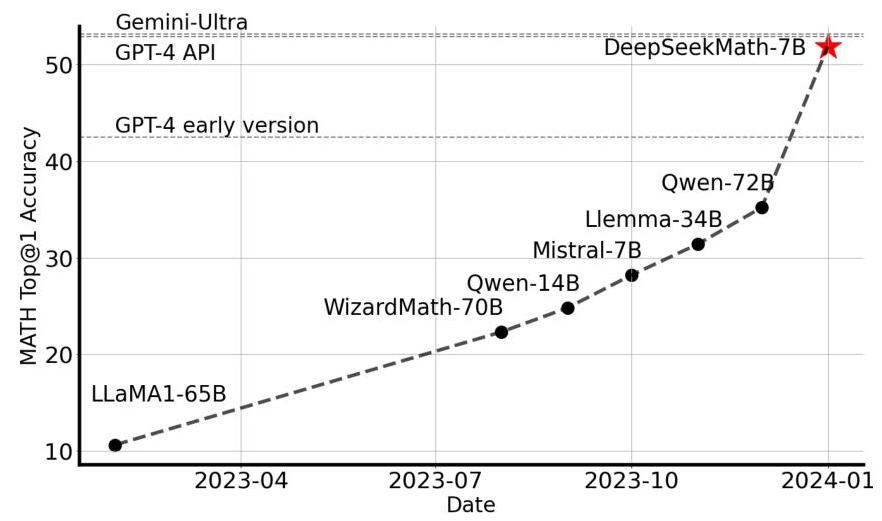

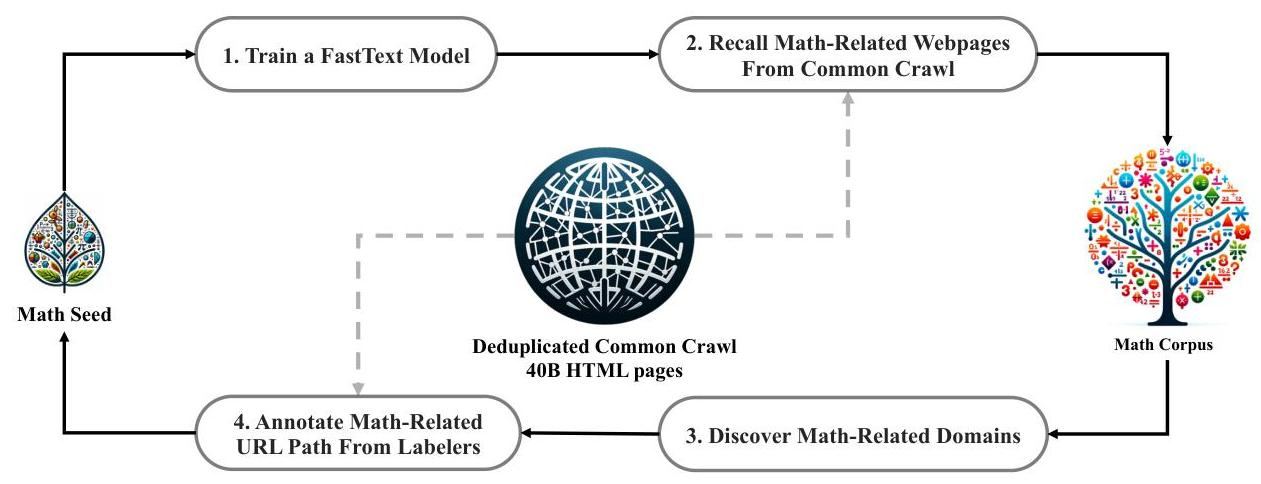

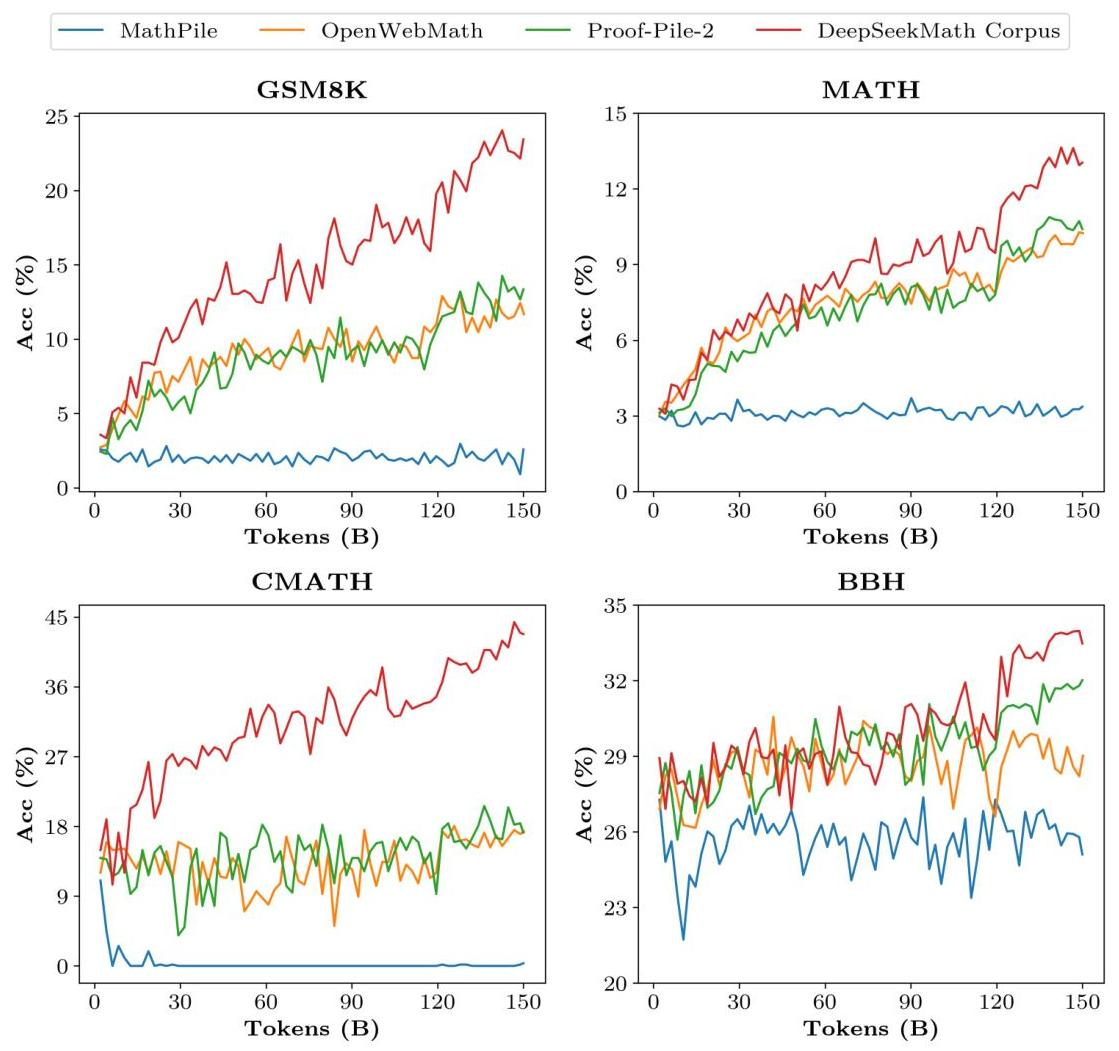

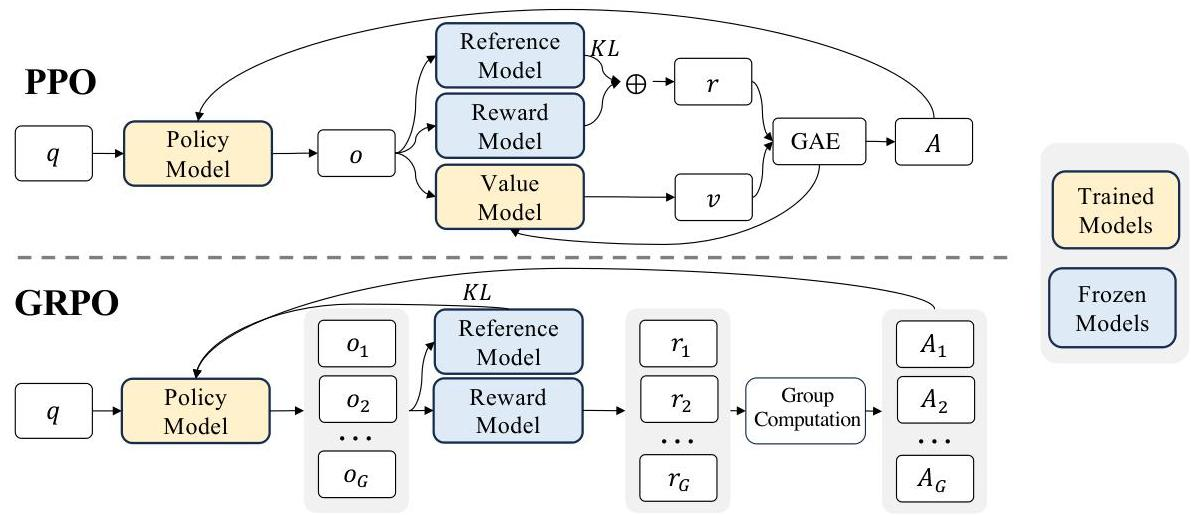

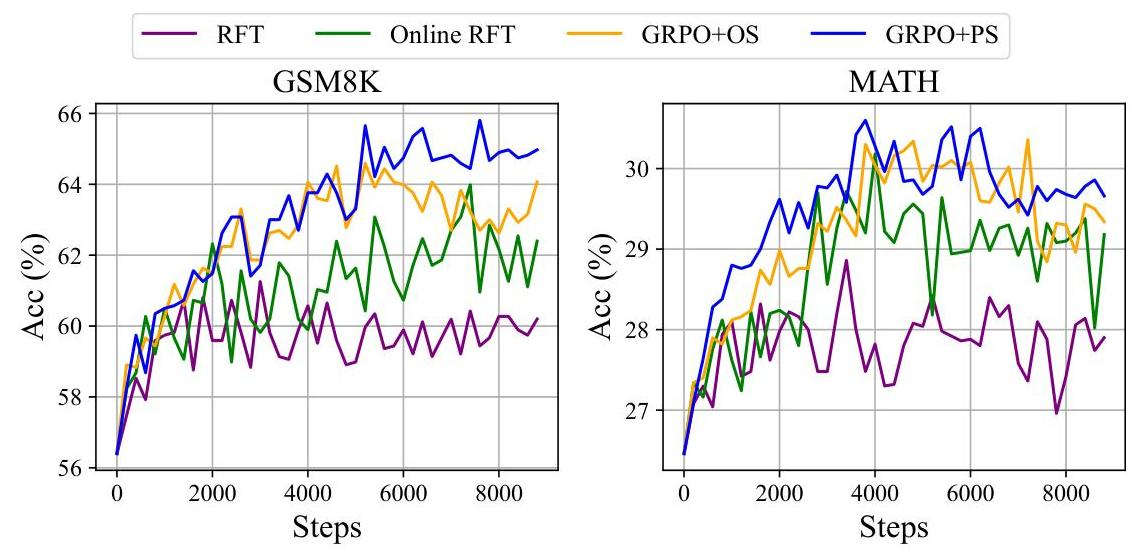

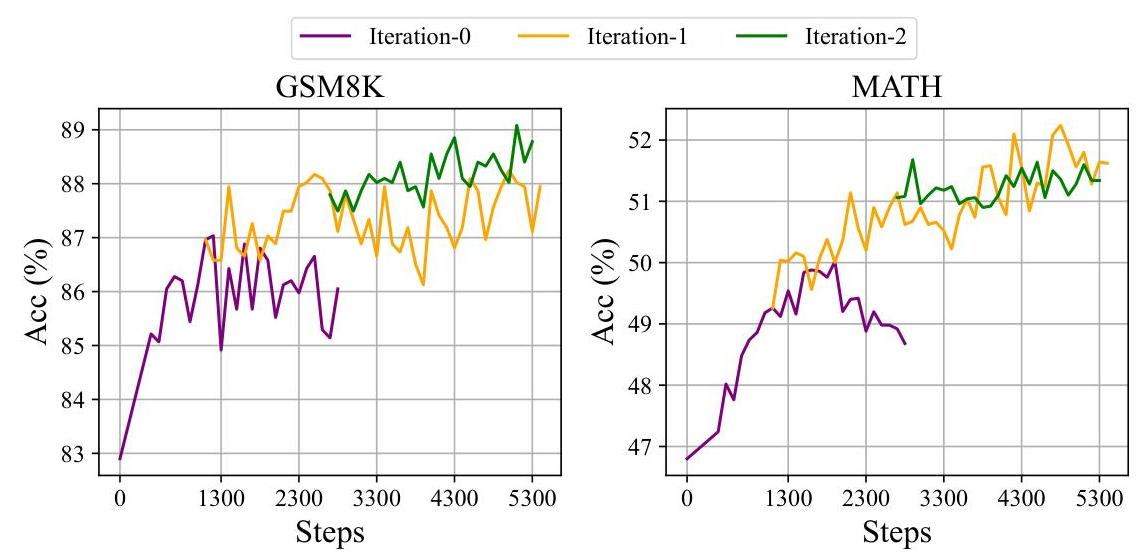

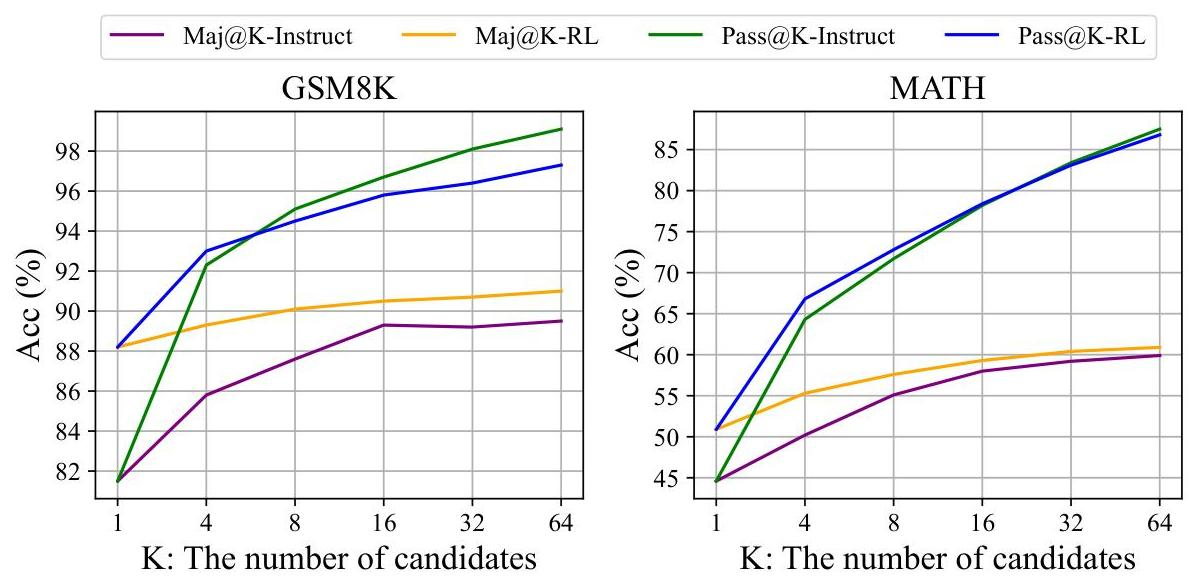

In [17]:
# ----- STEP 9: DISPLAY IMAGES REFERENCED IN THE RESULTS -----
for res in results:
    if "image_refs" in res.metadata:
        for img_ref in res.metadata["image_refs"]:
            img_path = os.path.join(images_dir, img_ref)
            if os.path.exists(img_path):
                display(IPyImage(filename=img_path))
            else:
                print(f"Image file {img_path} not found.")

# Summary

**Markdown Parsing**:
The script reads your markdown file and extracts image references via regex.

**Embedding Computation**:
It computes image embeddings using the CLIP model and averages them, computes a text embedding using OpenAIEmbeddings, then concatenates them into a combined vector.

**Vector Store Construction**:
A Document is created with the markdown text and metadata (containing image references), and a FAISS index is built from a tuple of (text, combined embedding).

**Query & Summarization**:
The FAISS index is queried. Because the retrieved text is long, it’s split into manageable chunks using `RecursiveCharacterTextSplitter`
. Then, a `map‐reduce` summarization chain produces a concise summary.

**Image Display**:
Finally, any image references found in the retrieved document metadata are loaded from “/content” and displayed.

